In [57]:
%reset
import sys, os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch
if torch.cuda.is_available():
    dev = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     dev = torch.device("mps")
else:
    dev = torch.device("cpu")

print(dev)
# dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook
# root_dir = '/global/cfs/cdirs/lsst/www/shivamp/CAMELS_NPE/'
# os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




mps
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
ji = 0
ns_d = 128
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
# z_all = [0, 0.5, 127]
# fields_all = ['Mtot','Mgas','ne', 'T','P']
fields_all = ['Mtot','Mgas']
ns_h = 128
# ns_h = 256
nax_h = ns_h // nb

# nsims_per_batch = 512
# nsims_per_batch = 128
nsims_per_batch = 256
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 1



In [59]:
hidden_dim_MAF = 5
K_Reg = 5
B_Reg = 2
nflows_Reg_NSF = 6
base_dist_Reg = 'gumbel'
changelr = False
ksize = nf
nfeature_cnn = 3
nout_cnn = 4 * nfeature_cnn
ninp = 1
# num_cond = nout_cnn + ninp
num_cond = nout_cnn



In [60]:
# Load the density data
df_d_all_train, df_pred_all_train, min_val_Mtot_tosub_train, min_vals_fields_tosub_train, sig_val_Mtot_todiv_train, sig_vals_fields_todiv_train = load_density_halo_data(
    ji, ns_d, nb, nf, nc, fields_all,
    sdir='/Users/shivam/Library/CloudStorage/Dropbox/research/camels_data'
    )

# Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_pred_all_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




0 256


Text(0, 0.5, 'Histogram')

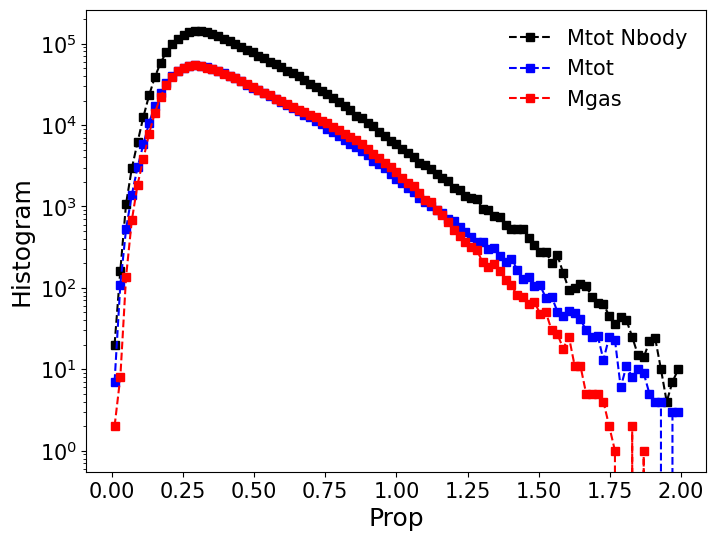

In [23]:
# len(return_dict_train['df_pred_all'])
# delta_min_p, delta_max_p = 10.5, 50.4
# indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
# bin_edges = np.linspace(-10,40,1000)
bin_edges = np.linspace(0,2,100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

hist_truth, _ = np.histogram(np.array(return_dict_train['df_d_all']).flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Mtot Nbody')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,0].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='Mtot')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,1].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='Mgas')

pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'Prop', size=18)
pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [61]:
# # len(return_dict_train['df_pred_all'])
# # delta_min_p, delta_max_p = 10.5, 50.4
# # indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
# pl.figure(figsize=(8,6))
# # bin_edges = np.linspace(-10,40,1000)
# bin_edges = np.linspace(0,20,100)
# bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

# hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,2].flatten(), bins=bin_edges)
# pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='ne')

# hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,3].flatten(), bins=bin_edges)
# pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='T')

# hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,4].flatten(), bins=bin_edges)
# pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='P')

# pl.yscale('log')
# pl.legend(fontsize=15, frameon=False)
# pl.tick_params(axis='both', which='major', labelsize=15)
# pl.tick_params(axis='both', which='minor', labelsize=15)
# pl.xlabel(r'Prop', size=18)
# pl.ylabel('Histogram', size=18)
# # pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [62]:
ndim_diff = return_dict_train['df_pred_all'][0].shape[2]
model_Reg = NSF_Reg_CNNcond(
    dim=ndim_diff,
    K=K_Reg,
    B=B_Reg,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    nflows=nflows_Reg_NSF,
    base_dist=base_dist_Reg,
    mu_pos=True
    )
model_Reg.to(dev)

print()



In [63]:
ndim = ndim_diff
model = COMBINED_Model(
    model_Reg,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Reg_cond=True,
    )

model.to(dev)

print()




In [64]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(1, 256, 22, 22, 22)

In [65]:
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20

cond_tensor = (np.array(return_dict_train['df_d_all']))
cond_tensor = np.reshape(cond_tensor, (cond_tensor.shape[0], cond_tensor.shape[1], 1, cond_tensor.shape[2], cond_tensor.shape[3], cond_tensor.shape[4]))
cond_tensor = torch.Tensor(cond_tensor).to(dev)
X_Reg = torch.Tensor(np.array(return_dict_train['df_pred_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff)).to(dev)

mask_tensor_Reg_train = torch.ones_like(X_Reg)



In [66]:
save_bestfit_model_name = './nf/save_check/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(8)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [67]:
ninit = 0
niterations = 200

# torch.autograd.set_detect_anomaly(False)
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    for g in optimizer.param_groups:
        g['lr'] = 0.005

    it = ito + ninit

    loss = model(
        X_Reg,
        cond_x=cond_tensor,
        mask_Reg_truth_all=mask_tensor_Reg_train,
        )

    loss.backward()
    optimizer.step()

    if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(
                state, save_bestfit_model_name
                )


            

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: Conv3D is not supported on MPS

tensor([1.], device='mps:0')


In [50]:
# Prepare the density and halo data
return_dict_test = prep_density_halo_cats(
    df_d_all_train, df_pred_all_train, nsims=nsims_per_batch,
    nstart = nsims_per_batch
    )
cond_tensor_test = (np.array(return_dict_test['df_d_all']))
cond_tensor_test = np.reshape(cond_tensor_test, (cond_tensor_test.shape[0], cond_tensor_test.shape[1], 1, cond_tensor_test.shape[2], cond_tensor_test.shape[3], cond_tensor_test.shape[4]))
cond_tensor_test = torch.Tensor(cond_tensor_test).to(dev)
X_Reg_test = torch.Tensor(np.array(return_dict_test['df_pred_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff)).to(dev)

mask_tensor_Reg_test = torch.ones_like(X_Reg_test)

Xreg_samp = model.inverse(
        cond_x=cond_tensor_test,
        mask_Reg_truth=mask_tensor_Reg_test[0,...],
        )




256 512


(0.5, 2.0)

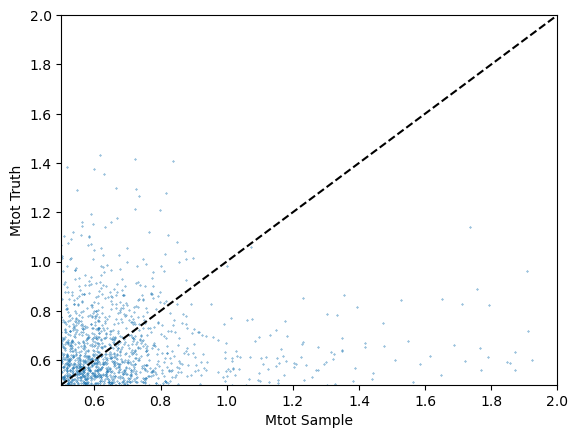

In [51]:
# Xreg_samp[jb][:,ind_M].cpu().detach().numpy().shape
pl.figure()
ind_M = 0
jb = 0
pl.scatter(Xreg_samp[jb][:,ind_M].cpu().detach().numpy()[:10000], X_Reg_test[jb][:,ind_M].cpu().detach().numpy()[:10000], s=0.1)
pl.plot([0,10],[0,10],ls='--', color='k')
pl.xlabel(r'Mtot Sample')
pl.ylabel(r'Mtot Truth')
pl.xlim(0.5,2)
pl.ylim(0.5,2)
# pl.ylabel('Histogram')
# pl.legend()





(0.5, 1.5)

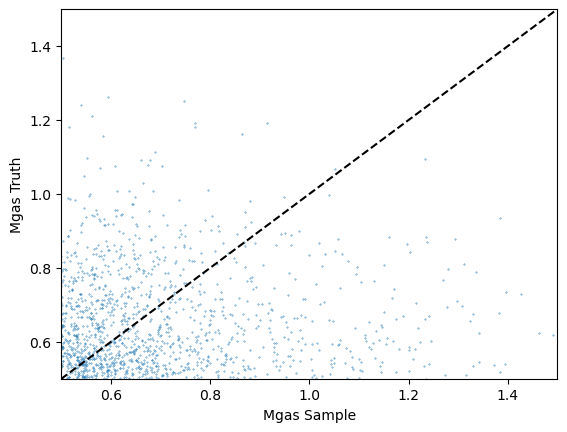

In [52]:
# Xreg_samp[jb][:,ind_M].cpu().detach().numpy().shape
pl.figure()
ind_M = 1
jb = 0
pl.scatter(Xreg_samp[jb][:,ind_M].cpu().detach().numpy()[:10000], X_Reg_test[jb][:,ind_M].cpu().detach().numpy()[:10000], s=0.1)
pl.plot([0,10],[0,10],ls='--', color='k')
pl.xlabel(r'Mgas Sample')
pl.ylabel(r'Mgas Truth')
pl.xlim(0.5,1.5)
pl.ylim(0.5,1.5)
# pl.ylabel('Histogram')
# pl.legend()




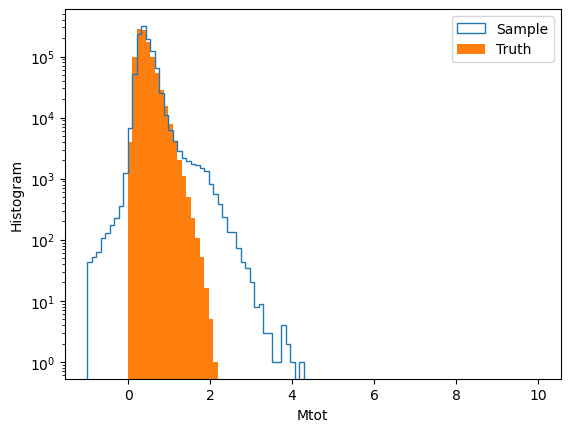

In [53]:
pl.figure()
ind_M = 0
jb = 0
# indp = mask_tensor_Reg_train[jb][:, ind_M] > 0
_ = pl.hist(Xreg_samp[jb][:,ind_M].cpu().detach().numpy(), range=(-1,10), bins=100, histtype='step', label='Sample')
# indp = mask_tensor_Reg_train[jb][:, ind_M] > 0
_ = pl.hist(X_Reg_test[jb][:,ind_M].cpu().detach().numpy(), range=(-1,10), bins=100, label='Truth')
pl.yscale('log')
pl.xlabel(r'Mtot')
pl.ylabel('Histogram')
pl.legend()





Text(0, 0.5, 'Histogram')

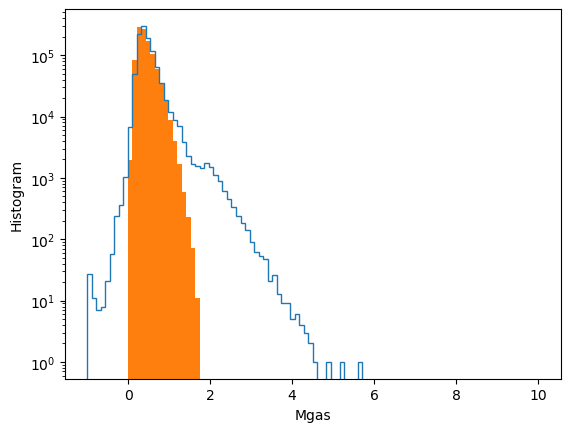

In [54]:
pl.figure()
ind_M = 1
jb = 0
# indp = mask_tensor_Reg_train[jb][:, ind_M] > 0
_ = pl.hist(Xreg_samp[jb][:,ind_M].cpu().detach().numpy(), range=(-1,10), bins=100, histtype='step')
# indp = mask_tensor_Reg_train[jb][:, ind_M] > 0
_ = pl.hist(X_Reg_test[jb][:,ind_M].cpu().detach().numpy(), range=(-1,10), bins=100)
pl.yscale('log')
pl.xlabel(r'Mgas')
pl.ylabel('Histogram')




